In [1]:
import os
import numpy as np
import cv2

from scipy.stats import norm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from scipy.stats import multivariate_normal

import math
import matplotlib.pyplot as plt
import numpy.matlib
from numpy.linalg import inv, det

In [2]:
dir_path = "C:/Users/chinm/Documents/Courses/Sem4/CV/Project/1/"

images_dir = "data/originalPics/"
fddb_file_path = "data/FDDB-folds/"
img_format = ".jpg"

output_dir = "data/output/"
bbox_fdd_folds = "bbox-FDDB-folds/"
bbox_faces_dir = "faces/"
bbox_non_faces_dir = "non_faces/"
face_dim = (20, 20)

model_path = "models/"

In [3]:
def get_files(path):
    files = []
    for root, subdirs, images in os.walk(path):
        if images:
            full_path_images = [os.path.join(root, image).replace("\\", "/") for image in images]
            files.extend(full_path_images)
    return files

In [4]:
def data_preparation():
    face_files = get_files(dir_path + output_dir + bbox_faces_dir)
    non_face_files = get_files(dir_path + output_dir + bbox_non_faces_dir)
    
    tr_face_data_images = face_files[:1000] 
    tr_non_face_data_images = non_face_files[:1000]
    
    te_face_data_images = face_files[1000:1100] 
    te_non_face_data_images = non_face_files[1000:1100]
    
    tr_face_data = [cv2.imread(img) for img in tr_face_data_images]
    tr_non_face_data = [cv2.imread(img) for img in tr_non_face_data_images]
    
    te_face_data = [cv2.imread(img) for img in te_face_data_images]
    te_non_face_data = [cv2.imread(img) for img in te_non_face_data_images]

    tr_face_data = np.array([cv2.normalize(i, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F).flatten() for i in tr_face_data])
    tr_non_face_data = np.array([cv2.normalize(i, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F).flatten() for i in tr_non_face_data])
    
    te_face_data = np.array([cv2.normalize(i, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F).flatten() for i in te_face_data])
    te_non_face_data = np.array([cv2.normalize(i, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F).flatten() for i in te_non_face_data])
    
    tr_face_labels = np.array([1]*1000)
    tr_non_face_labels = np.array([0]*1000)
    
    te_face_labels = np.array([1]*100)
    te_non_face_labels = np.array([0]*100)
    
    return tr_face_data, tr_non_face_data, tr_face_labels, tr_non_face_labels, te_face_data, te_non_face_data, te_face_labels, te_non_face_labels

In [5]:
tr_face_data, tr_non_face_data, tr_face_labels, tr_non_face_labels, te_face_data, te_non_face_data, te_face_labels, te_non_face_labels = data_preparation()
len(tr_face_data), len(tr_non_face_data), len(tr_face_labels), len(tr_non_face_labels), len(te_face_data), len(te_non_face_data), len(te_face_labels), len(te_non_face_labels)

(1000, 1000, 1000, 1000, 100, 100, 100, 100)

In [11]:
class SingleGaussian():
    def __init__(self, tr_face_data, tr_non_face_data, tr_face_labels, tr_non_face_labels, \
                 te_face_data, te_non_face_data, te_face_labels, te_non_face_labels, vec_len, img_dim=(20,20,3)):
        self.tr_face_data = tr_face_data
        self.tr_non_face_data = tr_non_face_data
        self.tr_face_labels = tr_face_labels
        self.tr_non_face_labels = tr_non_face_labels
        
        self.te_face_data = te_face_data
        self.te_non_face_data = te_non_face_data
        self.testing_data = np.concatenate((self.te_face_data, self.te_non_face_data), axis=0)
        
        self.te_face_labels = te_face_labels
        self.te_non_face_labels = te_non_face_labels
        
        self.vec_len = vec_len
        self.img_dim = img_dim
        
        self.storing_dir = "Single_Gaussian/"
        
    def fit(self):
        self.tr_f_mu = self.tr_face_data.mean(axis=0)
        self.tr_nf_mu = self.tr_non_face_data.mean(axis=0)
        
        self.tr_face_sigma = np.cov(self.tr_face_data, rowvar=False, bias=1, ddof=None)
        self.tr_face_sigma = np.diagonal(self.tr_face_sigma)
        self.tr_f_covariance = np.diag(self.tr_face_sigma, 0)
        
        self.tr_non_face_sigma = np.cov(self.tr_non_face_data, rowvar=False, bias=1, ddof=None)
        self.tr_non_face_sigma = np.diagonal(self.tr_non_face_sigma)
        self.tr_nf_covariance = np.diag(self.tr_non_face_sigma, 0)
                
    def pdf(self, data, mean, covs):
        print(data.shape, mean.shape, covs.shape)
        temp1 = np.matmul((data[:,0].reshape(-1,1)-mean[0]).T, inv(covs[0]))
        temp2 = -0.5*np.matmul(temp1, data[:,0].reshape(-1,1)-mean[0])
        pdf = np.exp(temp2)/(np.sqrt(det(covs[k]) * (2*np.pi**data.shape[0])))
        return pdf
        
    def predict(self):
        self.pred_labels = []
        self.pred_scores = []
        
        self.face_pdf = multivariate_normal.pdf(self.te_face_data, self.tr_f_mu, self.tr_f_covariance)
        self.non_face_pdf = multivariate_normal.pdf(self.te_non_face_data, self.tr_nf_mu, self.tr_nf_covariance) 
        
        self.face_predict_labels = [1 if i>0.5 else 0 for i in self.face_pdf]
        self.non_face_predict_labels = [0 if i>0.5 else 1 for i in self.non_face_pdf]
        
        self.pred_labels = self.face_predict_labels + self.non_face_predict_labels
        self.pred_scores = np.concatenate((self.face_pdf, self.non_face_pdf), axis=0)
    
    def visualze_mean_and_cov(self):
        self.mean_f_image = self.tr_f_mu.reshape(self.img_dim)
        self.mean_f_image =  self.mean_f_image*(255/np.max(self.mean_f_image))
        cov_f_image = np.diag(self.tr_f_covariance)
        cov_f_image = cov_f_image/np.max(cov_f_image)
        self.cov_f_image = cov_f_image.reshape(self.img_dim)
        self.cov_f_image =  self.cov_f_image*(255/np.max(self.cov_f_image))
        
        self.mean_nf_image = self.tr_nf_mu.reshape(self.img_dim)
        self.mean_nf_image =  self.mean_nf_image*(255/np.max(self.mean_nf_image))
        cov_nf_image = np.diag(self.tr_nf_covariance)
        cov_nf_image = cov_nf_image/np.max(cov_nf_image)
        self.cov_nf_image = cov_nf_image.reshape(self.img_dim)
        self.cov_nf_image =  self.cov_nf_image*(255/np.max(self.cov_nf_image))
        
        cv2.imwrite(dir_path + model_path + self.storing_dir + "Mean_Face_Image.jpg", self.mean_f_image)
        cv2.imwrite(dir_path + model_path + self.storing_dir + "Mean_Non_Face_Image.jpg", self.mean_nf_image)
        
        cv2.imwrite(dir_path + model_path + self.storing_dir + "Cov_Face_Image.jpg", self.cov_f_image)
        cv2.imwrite(dir_path + model_path + self.storing_dir + "Cov_Non_Face_Image.jpg", self.cov_nf_image)
            
        cv2.imwrite(dir_path + model_path + self.storing_dir + "Mean_Face_Image_resize.jpg", cv2.resize(self.mean_f_image, (60,60)))
        cv2.imwrite(dir_path + model_path + self.storing_dir + "Mean_Non_Face_Image_resize.jpg", cv2.resize(self.mean_nf_image, (60,60)))
        
        cv2.imwrite(dir_path + model_path + self.storing_dir + "Cov_Face_Image_resize.jpg", cv2.resize(self.cov_f_image, (60,60)))
        cv2.imwrite(dir_path + model_path + self.storing_dir + "Cov_Non_Face_Image_resize.jpg", cv2.resize(self.cov_nf_image, (60,60)))
            
    def create_confusion_matrix(self):
        self.testing_data_labels = np.concatenate((single_gaussian.te_face_labels, single_gaussian.te_non_face_labels), axis=0)
    
        TP = 0
        FP = 0
        TN = 0
        FN = 0

        for i in range(len(self.pred_labels)): 
            if self.testing_data_labels[i]==self.pred_labels[i]==1:
               TP += 1
            if self.pred_labels[i]==1 and self.testing_data_labels[i]!=self.pred_labels[i]:
               FP += 1
            if self.testing_data_labels[i]==self.pred_labels[i]==0:
               TN += 1
            if self.pred_labels[i]==0 and self.testing_data_labels[i]!=self.pred_labels[i]:
               FN += 1

        return(TP, FP, TN, FN)
        
    def plot_roc_curve(self):
        fpr, tpr, threshold = roc_curve(self.testing_data_labels, self.pred_scores)
        roc_auc = auc(fpr, tpr)

        # Plot ROC curve
        plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
        plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.xlabel('False Positive Rate or (1 - Specifity)')
        plt.ylabel('True Positive Rate or (Sensitivity)')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.savefig(dir_path + model_path + self.storing_dir + "Single_Gaussian_ROC_Curve.png")

In [12]:
single_gaussian = SingleGaussian(tr_face_data, tr_non_face_data, tr_face_labels, tr_non_face_labels, \
                                 te_face_data, te_non_face_data, te_face_labels, te_non_face_labels,\
                                1200, (20,20,3))

In [13]:
single_gaussian.fit()

In [14]:
single_gaussian.predict()

In [20]:
TP, FP, TN, FN = single_gaussian.create_confusion_matrix()

In [21]:
fpr =  FP/(FP+TN)
fnr = FN/(TP+FN)
mis_class_rate = (FP + FN)/200
print("False Positive Rate: {}".format(fpr))
print("False Negative Rate: {}".format(fnr))
print("Mis Classification Rate: {}".format(mis_class_rate))

False Positive Rate: 0.87
False Negative Rate: 0.35
Mis Classification Rate: 0.61


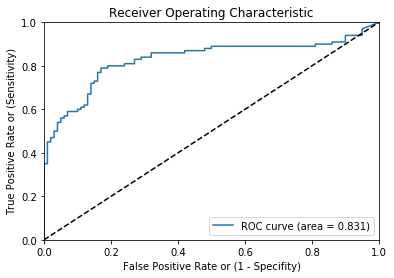

In [18]:
single_gaussian.plot_roc_curve()

In [19]:
single_gaussian.visualze_mean_and_cov()